Example Notebook
============

In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

from lda_for_fragments import Ms2Lda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sys
import visualisation.pyLDAvis as pyLDAvis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
n_topics = 400 # number of topics, 400 seems to be good from cross-validation
n_samples = 50 # how many samples to get during Gibbs sampling

n_burn = 0 # no. of burn-in samples to discard, unused
n_thin = 1 # thinning parameter, unused

# follow the recommendation from Griffith & Styver
alpha = 50.0/n_topics # hyper-parameter for document-topic distributions
beta = 0.1 # hyper-parameter for topic-word distributions

fragment_filename = basedir + 'input/relative_intensities/Beer_3_T10_POS_fragments_rel.csv'
neutral_loss_filename = basedir + 'input/relative_intensities/Beer_3_T10_POS_losses_rel.csv'
mzdiff_filename = None

ms1_filename = basedir + 'input/relative_intensities/Beer_3_T10_POS_ms1_rel.csv'
ms2_filename = basedir + 'input/relative_intensities/Beer_3_T10_POS_ms2_rel.csv'

In [25]:
ms2lda = Ms2Lda(fragment_filename, neutral_loss_filename, mzdiff_filename, 
                ms1_filename, ms2_filename, relative_intensity=True)
df, vocab = ms2lda.preprocess()

Data shape (856, 1664)


In [26]:
ms2lda.run_lda(df, vocab, n_topics, n_samples, n_burn, n_thin, 
               alpha, beta, use_own_model=True, use_native=True)

Fitting model...
CGS LDA initialising
......................................................................................
Using Numba for LDA sampling
Preparing words
Preparing Z matrix
DONE
Sample 1   Log joint likelihood = -3290884.011 
Sample 2   Log joint likelihood = -2101706.039 
Sample 3   Log joint likelihood = -1558905.402 
Sample 4   Log joint likelihood = -1388784.302 
Sample 5   Log joint likelihood = -1316030.825 
Sample 6   Log joint likelihood = -1276246.474 
Sample 7   Log joint likelihood = -1253508.982 
Sample 8   Log joint likelihood = -1236643.844 
Sample 9   Log joint likelihood = -1221421.259 
Sample 10   Log joint likelihood = -1209065.510 
Sample 11   Log joint likelihood = -1200262.033 
Sample 12   Log joint likelihood = -1191446.933 
Sample 13   Log joint likelihood = -1183412.672 
Sample 14   Log joint likelihood = -1178194.408 
Sample 15   Log joint likelihood = -1172773.213 
Sample 16   Log joint likelihood = -1168721.917 
Sample 17   Log joint likelihoo

In [27]:
ms2lda.write_results('beer3_pos_rel')

Writing topics to results/beer3_pos_rel/beer3_pos_rel_topics.csv
Writing fragments x topics to results/beer3_pos_rel/beer3_pos_rel_all.csv
Writing topic docs to results/beer3_pos_rel/beer3_pos_rel_docs.csv


2. LDAVis
----------

Visualise topics using LDAVis. First prepare the data to display.

In [28]:
data = {}
data['topic_term_dists'] = ms2lda.model.topic_word_
data['doc_topic_dists'] = ms2lda.model.doc_topic_
data['doc_lengths'] = ms2lda.model.cd
data['vocab'] = ms2lda.model.vocab
data['term_frequency'] = np.sum(ms2lda.model.ckn, axis=0)

In [29]:
print np.sum(ms2lda.model.ckn, axis=0).shape

(1664,)


Check to make sure everything's correct ..

Topic-Term shape: (400, 1664)
Doc-Topic shape: (856, 400)
856
<type 'numpy.ndarray'>
fragment_51.0234
fragment_52.01851
(400, 1664)
(856, 400)
(856,)
(1664,)


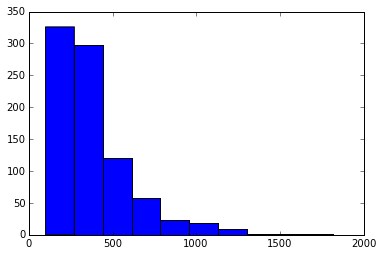

In [30]:
print('Topic-Term shape: %s' % str(data['topic_term_dists'].shape))
print('Doc-Topic shape: %s' % str(data['doc_topic_dists'].shape))
print len(data['doc_lengths'])
plt.hist(data['doc_lengths'])
print type(data['vocab'])
print data['vocab'][0]
print data['vocab'][1]
print data['topic_term_dists'].shape
print data['doc_topic_dists'].shape
print data['doc_lengths'].shape
print data['term_frequency'].shape

In [35]:
vis_data = pyLDAvis.prepare(**data)

In [36]:
pyLDAvis.display(vis_data)

In [33]:
ms2lda.model.print_topic_words()

Topic 0: fragment_98.98387 (0.492531188444), loss_120.04178 (0.188854235062), fragment_211.10574 (0.154382797111),
Topic 1: loss_154.02954 (0.151098545345), fragment_58.06553 (0.14915612725), loss_140.01437 (0.104048862606), fragment_72.08072 (0.103833038374), fragment_123.01112 (0.0980057840894), loss_122.00401 (0.0680062157379), fragment_90.09112 (0.0677903915052),
Topic 2: loss_102.06815 (0.764673433363),
Topic 3: loss_18.01103 (0.698269835722), fragment_258.13332 (0.0865955959455), loss_190.04798 (0.0507689619014),
Topic 4: fragment_96.08073 (0.295962509012), fragment_142.08712 (0.0580389329488),
Topic 5: loss_46.00544 (0.92942281159),
Topic 6: fragment_101.04037 (0.215546942291), loss_18.00834 (0.122954349699), fragment_295.17133 (0.118647717485), fragment_128.06203 (0.0928079242033), fragment_143.08514 (0.0841946597761),
Topic 7: fragment_107.06036 (0.175189920326), loss_132.0896 (0.0955160274226), loss_105.07856 (0.0936631461923), fragment_134.07171 (0.0927367055772), fragment_8

3. Shared Fragments within a Topic
--------------------------------------

For every topic, we visualise the interesting 'words' shared in common across the documents. Topics are ordered in the list below by their 'h-indices'. The consistency score (0.50 in below case) is then used to highlight interesting peaks in the plot. 0.50 means the word (fragment/loss) is present in at least 50% of the selected parent peaks for this topic. 

In [34]:
# ms2lda.plot_lda_fragments(consistency=0.50, sort_by="h_index")
# ms2lda.plot_lda_fragments(consistency=0.50, sort_by="in_degree")